## need to convert bedmachine v2 topography x,y coords in metres to lat/long
https://sites.uci.edu/morlighem/dataproducts/bedmachine-antarctica/

see also doc in /g/data/v45/pas561/bedmachineant/
The projection is Polar Stereographic South (71ºS, 0ºE), which corresponds to
ESPG 3031

In [1]:
import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import xarray as xr
import cartopy.crs as ccrs
import cmocean as cm
from collections import OrderedDict
import cftime
import glob

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client
import matplotlib.path as mpath

import cmocean.cm as cmocean
from mpl_toolkits.axes_grid1 import make_axes_locatable

from pyproj import Proj, transform

In [2]:
client = Client(n_workers=8)
client

Client Scheduler: tcp://127.0.0.1:36933 Dashboard: /proxy/8787/status,Cluster Workers: 8 Cores: 8 Memory: 100.00 GiB


see also doc in /g/data/v45/pas561/bedmachineant/
All heights are referenced to mean sea level (using the geoid EIGEN-6C4). To convert the heights to heightsreferenced to the WGS84 ellipsoid, simply add the geoid height

In [3]:
bedbathy=xr.open_mfdataset('/g/data/v45/pas561/bedmachineant/BedMach*.nc',engine='netcdf4',decode_times=False)

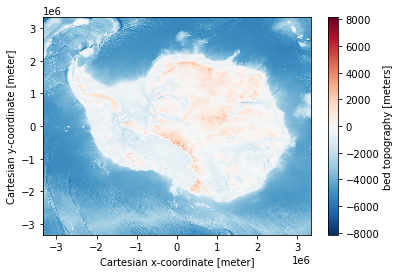

In [4]:
#takes a long time to plot full file
bedbathy.bed.plot.pcolormesh()

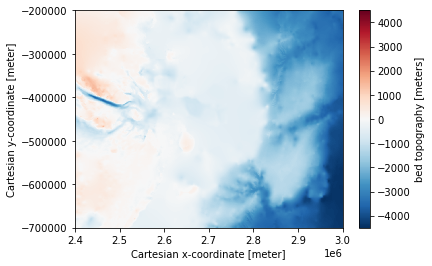

In [5]:
#plot denman region --- want this to be in lat/lon coords instead of metres
bedbathy.bed.sel(y=slice(-.2e6,-.7e6)).sel(x=slice(2.4e6,3e6)).plot.pcolormesh()

In [6]:
bedbathy

<xarray.Dataset>
Dimensions:    (x: 13333, y: 13333)
Coordinates:
  * x          (x) int32 -3333000 -3332500 -3332000 ... 3332000 3332500 3333000
  * y          (y) int32 3333000 3332500 3332000 ... -3332000 -3332500 -3333000
Data variables:
    mapping    |S1 ...
    mask       (y, x) int8 dask.array<chunksize=(13333, 13333), meta=np.ndarray>
    firn       (y, x) float32 dask.array<chunksize=(13333, 13333), meta=np.ndarray>
    surface    (y, x) float32 dask.array<chunksize=(13333, 13333), meta=np.ndarray>
    thickness  (y, x) float32 dask.array<chunksize=(13333, 13333), meta=np.ndarray>
    bed        (y, x) float32 dask.array<chunksize=(13333, 13333), meta=np.ndarray>
    errbed     (y, x) float32 dask.array<chunksize=(13333, 13333), meta=np.ndarray>
    source     (y, x) int8 dask.array<chunksize=(13333, 13333), meta=np.ndarray>
    geoid      (y, x) int16 dask.array<chunksize=(13333, 13333), meta=np.ndarray>
Attributes: (12/17)
    Conventions:                 CF-1.7
    Title:                       BedMachine Antarctica
    Author:                      Mathieu Morlighem
    version:                     15-Jul-2020 (v2.0)
    nx:                          13333.0
    ny:                          13333.0
    ...                          ...
    ymax:                        3333000
    spacing:                     500
    no_data:                     -9999.0
    license:                     No restrictions on access or use
    Data_citation:               Morlighem M. et al., (2019), Deep glacial tr...
    Notes:                       Data processed at the Department of Earth Sy...

In [7]:
#from doc in /g/data/v45/pas561/bedmachineant/
#The projection is Polar Stereographic South (71ºS, 0ºE), which corresponds to
#ESPG 3031
inProj="epsg:3031"

#https://spatialreference.org/ref/epsg/wgs-84/
outProj="epsg:4326"

In [8]:
xx, yy = np.meshgrid(bedbathy.x.values, bedbathy.y.values)

In [9]:
x2,y2 = transform(inProj,outProj, xx, yy)
#print(x2,y2)
print(np.min(x2),np.max(x2),np.min(y2),np.max(y2))

-90.0 -48.464383106398614 -179.99140477361487 180.0


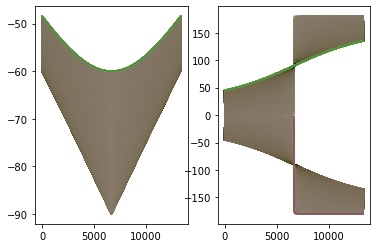

In [23]:
#Note transpose of x and y for the plot as this is the way it is laid out in the datafile
plt.subplot(1,2,1)
plt.plot(x2);
plt.subplot(1,2,2)
plt.plot(y2);

In [34]:
master_session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')
expt = '01deg_jra55v13_ryf9091'
variable='xt_ocean'
xt_ocean = cc.querying.getvar(expt,variable,master_session, n=-1)
xt_ocean.load()
print(xt_ocean.shape)

variable='yt_ocean'
yt_ocean = cc.querying.getvar(expt,variable,master_session, n=-1)
yt_ocean.load()
print(yt_ocean.shape)

(3600,)
(2700,)


In [35]:
print(np.min(x2),np.max(x2),np.min(y2),np.max(y2))

-90.0 -48.464383106398614 -179.99140477361487 180.0


In [38]:
yt_ocean

<xarray.DataArray 'yt_ocean' (yt_ocean: 2700)>
array([-81.108632, -81.066392, -81.024153, ...,  89.894417,  89.936657,
        89.978896])
Coordinates:
  * yt_ocean  (yt_ocean) float64 -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
Attributes:
    long_name:       tcell latitude
    units:           degrees_N
    cartesian_axis:  Y

In [41]:
yt_ocean = yt_ocean.sel(yt_ocean=slice(-90,-48))

In [42]:
yt_ocean

<xarray.DataArray 'yt_ocean' (yt_ocean: 696)>
array([-81.108632, -81.066392, -81.024153, ..., -48.194486, -48.127782,
       -48.060992])
Coordinates:
  * yt_ocean  (yt_ocean) float64 -81.11 -81.07 -81.02 ... -48.19 -48.13 -48.06
Attributes:
    long_name:       tcell latitude
    units:           degrees_N
    cartesian_axis:  Y

In [29]:
#list(x2[:,0])
x3=np.unique(x2)

In [30]:
x3.shape

(12371480,)

In [11]:
bedbathy = bedbathy.assign_coords({'x2': (('y', 'x'), x2), 'y2': (('y', 'x'), y2)})
bedbathy

<xarray.Dataset>
Dimensions:    (x: 13333, y: 13333)
Coordinates:
  * x          (x) int32 -3333000 -3332500 -3332000 ... 3332000 3332500 3333000
  * y          (y) int32 3333000 3332500 3332000 ... -3332000 -3332500 -3333000
    x2         (y, x) float64 -48.46 -48.47 -48.47 ... -48.47 -48.47 -48.46
    y2         (y, x) float64 -45.0 -45.0 -44.99 -44.99 ... 135.0 135.0 135.0
Data variables:
    mapping    |S1 ...
    mask       (y, x) int8 dask.array<chunksize=(13333, 13333), meta=np.ndarray>
    firn       (y, x) float32 dask.array<chunksize=(13333, 13333), meta=np.ndarray>
    surface    (y, x) float32 dask.array<chunksize=(13333, 13333), meta=np.ndarray>
    thickness  (y, x) float32 dask.array<chunksize=(13333, 13333), meta=np.ndarray>
    bed        (y, x) float32 dask.array<chunksize=(13333, 13333), meta=np.ndarray>
    errbed     (y, x) float32 dask.array<chunksize=(13333, 13333), meta=np.ndarray>
    source     (y, x) int8 dask.array<chunksize=(13333, 13333), meta=np.ndarray>
    geoid      (y, x) int16 dask.array<chunksize=(13333, 13333), meta=np.ndarray>
Attributes: (12/17)
    Conventions:                 CF-1.7
    Title:                       BedMachine Antarctica
    Author:                      Mathieu Morlighem
    version:                     15-Jul-2020 (v2.0)
    nx:                          13333.0
    ny:                          13333.0
    ...                          ...
    ymax:                        3333000
    spacing:                     500
    no_data:                     -9999.0
    license:                     No restrictions on access or use
    Data_citation:               Morlighem M. et al., (2019), Deep glacial tr...
    Notes:                       Data processed at the Department of Earth Sy...

In [ ]:
fig = plt.figure(figsize=(10, 9))
projection=ccrs.SouthPolarStereo()
ax = plt.axes(projection=projection)
ax.coastlines(resolution='50m')
bedbathy.bed.plot.pcolormesh(ax=ax, x='y2', y='x2', transform=ccrs.PlateCarree())
ax.coastlines();

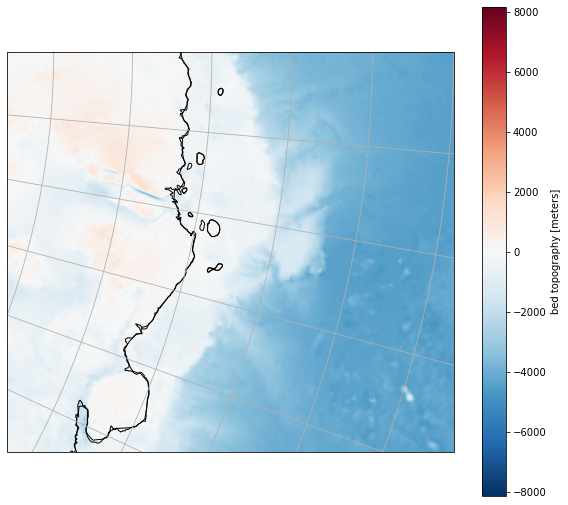

In [15]:
fig = plt.figure(figsize=(10, 9))
projection=ccrs.SouthPolarStereo()
ax = plt.axes(projection=projection)

ax.set_extent([90, 110, -70, -60], crs=ccrs.PlateCarree())
ax.coastlines(resolution='50m')

ax.gridlines()
bedbathy.bed.plot(ax=ax, x='y2', y='x2', transform=ccrs.PlateCarree())

ax.coastlines();

In [46]:
(yt_ocean[-1],xt_ocean[-1])

(<xarray.DataArray 'yt_ocean' ()>
 array(-48.060992)
 Coordinates:
     yt_ocean  float64 -48.06
 Attributes:
     long_name:       tcell latitude
     units:           degrees_N
     cartesian_axis:  Y,
 <xarray.DataArray 'xt_ocean' ()>
 array(79.95)
 Coordinates:
     xt_ocean  float64 79.95
 Attributes:
     long_name:       tcell longitude
     units:           degrees_E
     cartesian_axis:  X)

Exception during reset or similar
Traceback (most recent call last):
  File "/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.04/lib/python3.8/site-packages/sqlalchemy/pool/base.py", line 697, in _finalize_fairy
    fairy._reset(pool)
  File "/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.04/lib/python3.8/site-packages/sqlalchemy/pool/base.py", line 893, in _reset
    pool._dialect.do_rollback(self)
  File "/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.04/lib/python3.8/site-packages/sqlalchemy/engine/default.py", line 558, in do_rollback
    dbapi_connection.rollback()
sqlite3.ProgrammingError: SQLite objects created in a thread can only be used in that same thread. The object was created in thread id 22647717746496 and this is thread id 22645111691008.
Exception closing connection <sqlite3.Connection object at 0x1497e0b138a0>
Traceback (most recent call last):
  File "/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.04/lib/python3.8/site-packages/sqlalchemy/po

In [45]:
bedbathy.sel(x2=(yt_ocean[-1],xt_ocean[-1]), y2=(yt_ocean[-1],xt_ocean[-1]), method='nearest')

ValueError: dimensions or multi-index levels ['x2', 'y2'] do not exist

In [18]:
bb2=bedbathy.bed.transpose()
bb2

<xarray.DataArray 'bed' (x: 13333, y: 13333)>
dask.array<transpose, shape=(13333, 13333), dtype=float32, chunksize=(13333, 13333), chunktype=numpy.ndarray>
Coordinates:
  * x        (x) int32 -3333000 -3332500 -3332000 ... 3332000 3332500 3333000
  * y        (y) int32 3333000 3332500 3332000 ... -3332000 -3332500 -3333000
    x2       (x, y) float64 -48.46 -48.47 -48.47 -48.47 ... -48.47 -48.47 -48.46
    y2       (x, y) float64 -45.0 -45.0 -45.01 -45.01 ... 135.0 135.0 135.0
Attributes:
    long_name:      bed topography
    standard_name:  bedrock_altitude
    units:          meters
    grid_mapping:   mapping
    source:         IBCSO and Mathieu Morlighem

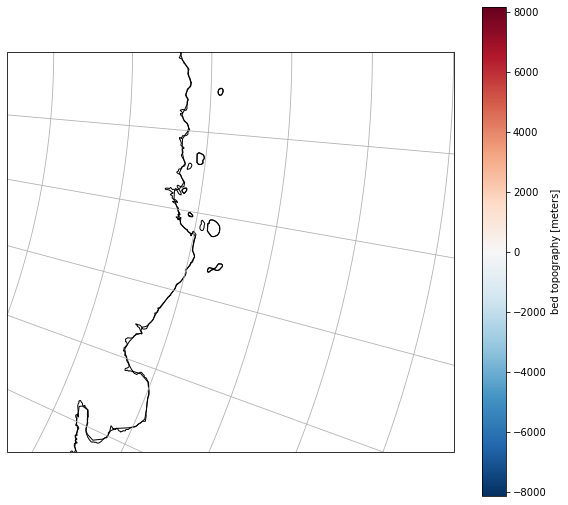

In [31]:
fig = plt.figure(figsize=(10, 9))
projection=ccrs.SouthPolarStereo()
ax = plt.axes(projection=projection)

ax.set_extent([90, 110, -70, -60], crs=ccrs.PlateCarree())
ax.coastlines(resolution='50m')

ax.gridlines()
bb2.plot(ax=ax, x='x2', y='y2', transform=ccrs.PlateCarree())

ax.coastlines();

In [21]:
bedbathy.to_netcdf('tst.nc')

KeyboardInterrupt: 

distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting


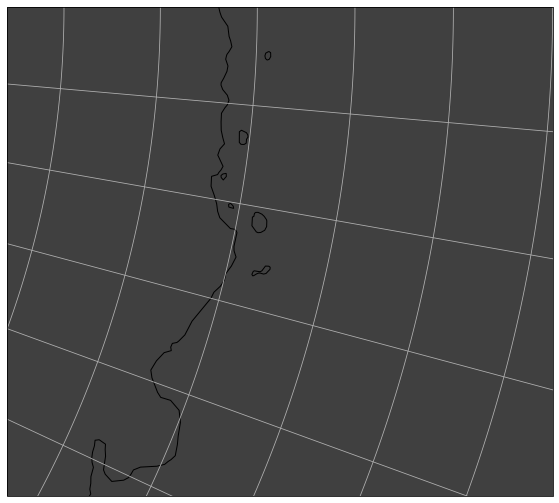

distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker


In [16]:
#plot using new lat lon coords .... 
clev = np.arange(-6000,0,10)
clev2 = np.arange(-6000,0,500)
fontsize=12

fig = plt.figure(figsize=(10, 9))
projection=ccrs.SouthPolarStereo()
ax = plt.axes(projection=projection)

ax.set_extent([90, 110, -70, -60], crs=ccrs.PlateCarree())
ax.coastlines(resolution='50m')

ax.gridlines()

plt.gca().patch.set_color('.25')
p1=plt.contourf(bedbathy.y2,bedbathy.x2,bedbathy.bed,levels=clev,cmap=plt.cm.cool)
#plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=clev2,colors='k',linewidths=0.25)
plt.xlabel('Longitude ($^\circ$)')
plt.ylabel('Latitude ($^\circ$)')
#plt.ylim([-90,-60])
#plt.xlim([-270,-250])
plt.title('BedMachineAntarctica v2 bathy',fontsize = 16)
# colorbar:
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.2)
cbar = plt.colorbar(p1, cax=cax,orientation = 'vertical',extend = 'neither')
cbar.set_label(r'Depth (m)',fontsize=fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=fontsize)